In [1]:

%pip install xgboost catboost streamlit --quiet


Note: you may need to restart the kernel to use updated packages.


# Olist E-Commerce Data Science Project

End-to-end, analysis and modeling on the Brazilian Olist multi-table e-commerce dataset.



**Sections**

1. Setup & Project Configuration

2. Data Loading & Cleaning

3. Exploratory Data Analysis (EDA)

4. Feature Engineering

5. Predictive Modeling

6. Business Insights & KPI Summary

7. Executive Summary & Streamlit Dashboard Sketch



> Business Goal: Use Olist’s historical data to understand and predict sales, delivery delays, and customer satisfaction, and to derive actionable recommendations for operations, logistics, and retention.

In [2]:
# 1. Setup & Project Configuration

# Purpose: Configure paths, import libraries, and ensure reproducibility.


from pathlib import Path
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Make src/ importable
PROJECT_ROOT = Path('..').resolve()
SRC_DIR = PROJECT_ROOT / 'src'
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

from utils import (
    PROJECT_ROOT as PRJ_ROOT,
    DATA_DIR,
    FIGURES_DIR,
    OUTPUTS_DIR,
    set_global_seed,
    save_figure,
)
from data_loading import (
    load_raw_olist_data,
    standardize_types_and_clean,
    enrich_products_with_translation,
    build_base_order_dataset,
)
from feature_engineering import (
    add_time_features,
    add_delivery_features,
    add_monetary_features,
    add_customer_clv_features,
    add_review_aggregates,
    add_geolocation_distance,
    build_model_feature_sets,
    add_binary_review_target,
)
from eda import (
    plot_missingness,
    plot_univariate_distributions,
    plot_time_series,
    plot_category_and_seller_performance,
    plot_geography_and_payments,
    plot_delivery_and_correlations,
)
from modeling import (
    build_delay_dataset,
    train_delay_models,
    build_review_dataset,
    train_review_models,
    train_binary_review_models,
    build_and_train_clv_model,
)

# Global plotting style and seed
set_global_seed()
sns.set(style='whitegrid', context='notebook')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

PRJ_ROOT, DATA_DIR, FIGURES_DIR, OUTPUTS_DIR

(PosixPath('/Users/mac/Desktop/business-data-science/Olist-DS-Project'),
 PosixPath('/Users/mac/Desktop/business-data-science/Olist-DS-Project/data'),
 PosixPath('/Users/mac/Desktop/business-data-science/Olist-DS-Project/figures'),
 PosixPath('/Users/mac/Desktop/business-data-science/Olist-DS-Project/outputs'))

In [3]:
# 2. Data Loading & Cleaning

# Purpose: Load all raw Olist CSVs, standardize data types, clean, and build base tables.

# Load raw tables

raw_tables = load_raw_olist_data()

{name: df.shape for name, df in raw_tables.items()}

{'customers': (99441, 5),
 'geolocation': (1000163, 5),
 'orders': (99441, 8),
 'order_items': (112650, 7),
 'payments': (103886, 5),
 'reviews': (99224, 7),
 'products': (32951, 9),
 'sellers': (3095, 4),
 'category_translation': (71, 2)}

In [4]:
# Continue cleaning and build base order-level dataset



clean_tables = standardize_types_and_clean(raw_tables)



# Enrich products with translated categories

clean_tables['products'] = enrich_products_with_translation(

    clean_tables['products'], clean_tables['category_translation']

)



# Build base orders and extended order_items table

orders_base, order_items_ext = build_base_order_dataset(clean_tables)



orders_base.head(3)

/Users/mac/Desktop/business-data-science/Olist-DS-Project/src/data_loading.py:176: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  order_items.groupby("order_id").agg(


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,customer_state,n_items,items_price_sum,freight_value_sum,payment_value_sum,payment_type_mode,payment_installments_max,review_score_latest,review_creation_date_max,review_answer_timestamp_max
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,SP,1.0,29.99,8.72,38.71,voucher,1.0,4.0,2017-10-11,2017-10-12 03:43:48
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,BA,1.0,118.70,22.76,141.46,boleto,1.0,4.0,2018-08-08,2018-08-08 18:37:50
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,GO,1.0,159.90,19.22,179.12,credit_card,3.0,5.0,2018-08-18,2018-08-22 19:07:58


## 3. Exploratory Data Analysis (EDA)



In this section we:

- Summarize the enriched dataset structure and missingness.

- Explore univariate distributions for monetary and satisfaction metrics.

- Analyze orders and revenue over time.

- Examine top product categories and sellers.

- Look at customer geography, freight vs price, and payment behavior.

- Study delivery delay patterns and correlations between key numeric variables.



Each chart is accompanied by business commentary in the surrounding markdown.

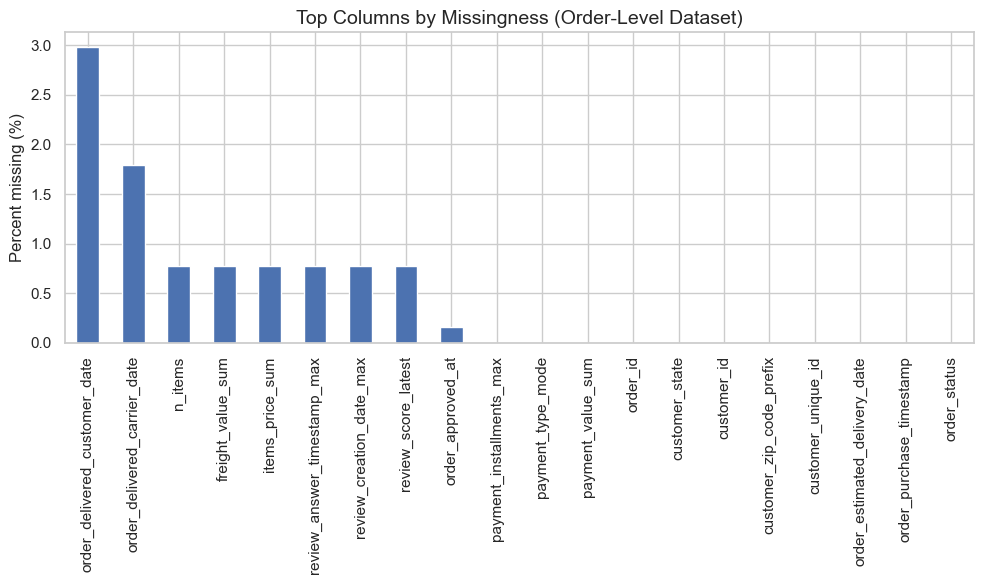

In [5]:
# 3.1 Dataset Overview & Missingness



# Basic shape and schema

orders_base.shape, orders_base.dtypes.head()


plot_missingness(orders_base)

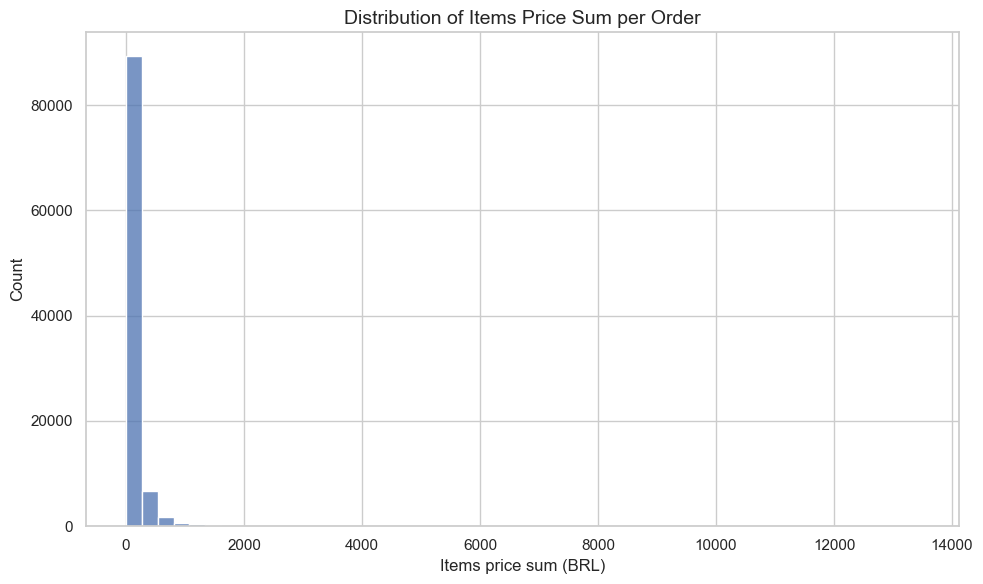

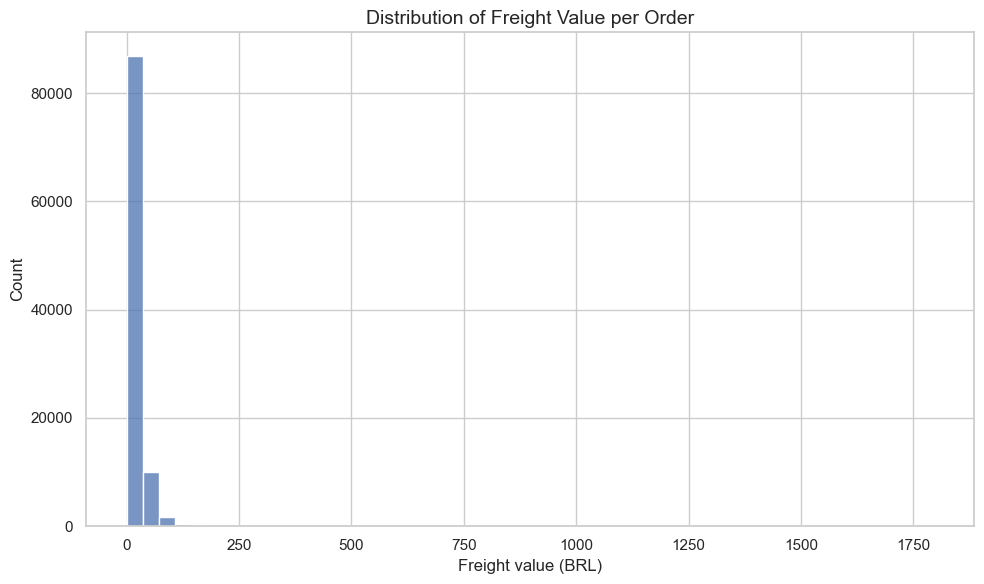

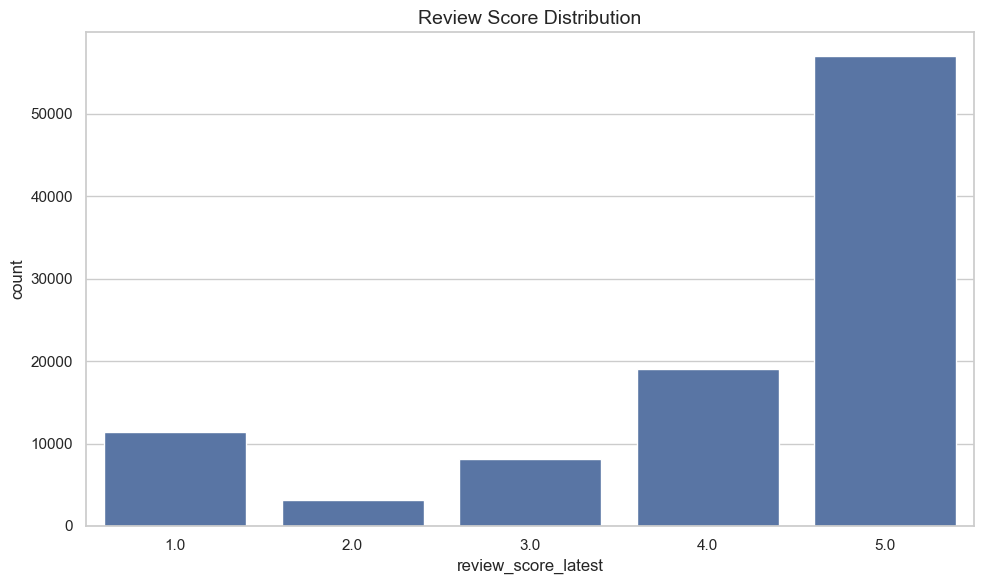

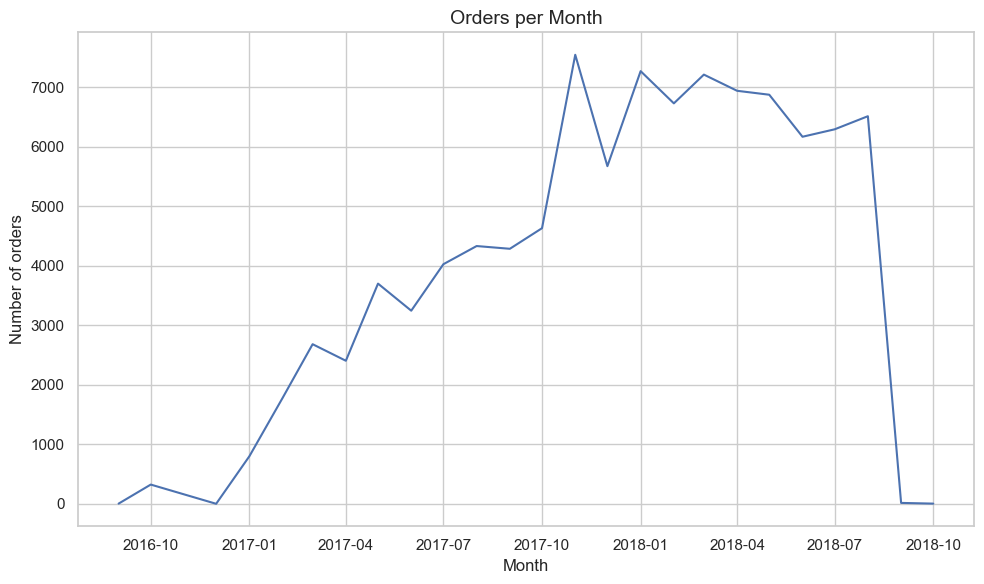

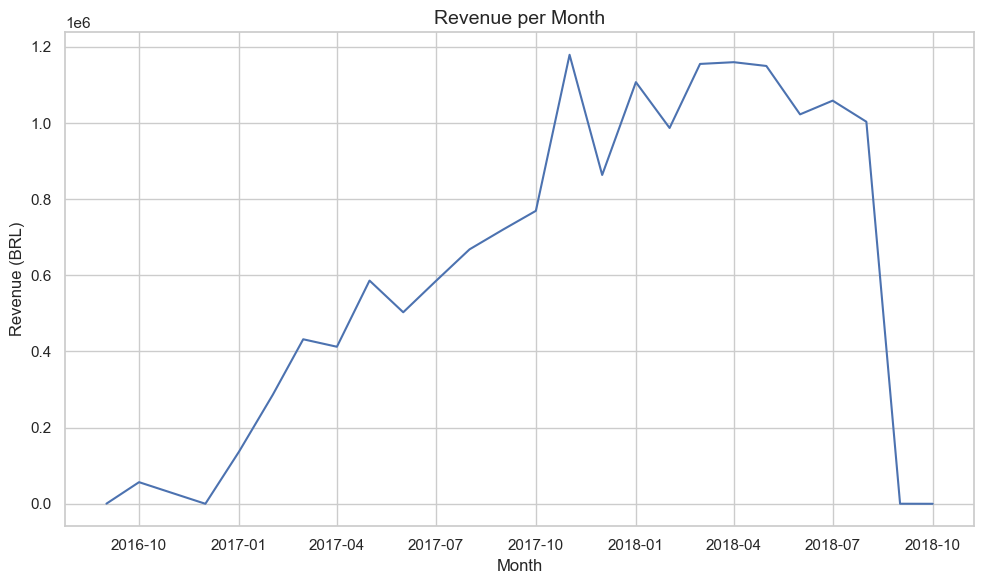

In [6]:
# 3.2 Univariate Distributions and Time-Series Behavior



# Add basic monetary and time features needed for EDA

orders_eda = add_monetary_features(add_time_features(orders_base))



# Monthly aggregation for orders and revenue

ts_orders = orders_eda.groupby('order_purchase_date').agg(

    n_orders=('order_id', 'count'),

    revenue=('total_order_value', 'sum'),

).reset_index()



plot_univariate_distributions(orders_eda)

plot_time_series(ts_orders)

/var/folders/kj/l_jbtj9n7678blgcl5zmd3xm0000gn/T/ipykernel_7842/649258285.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  items_with_seller.groupby('seller_id')


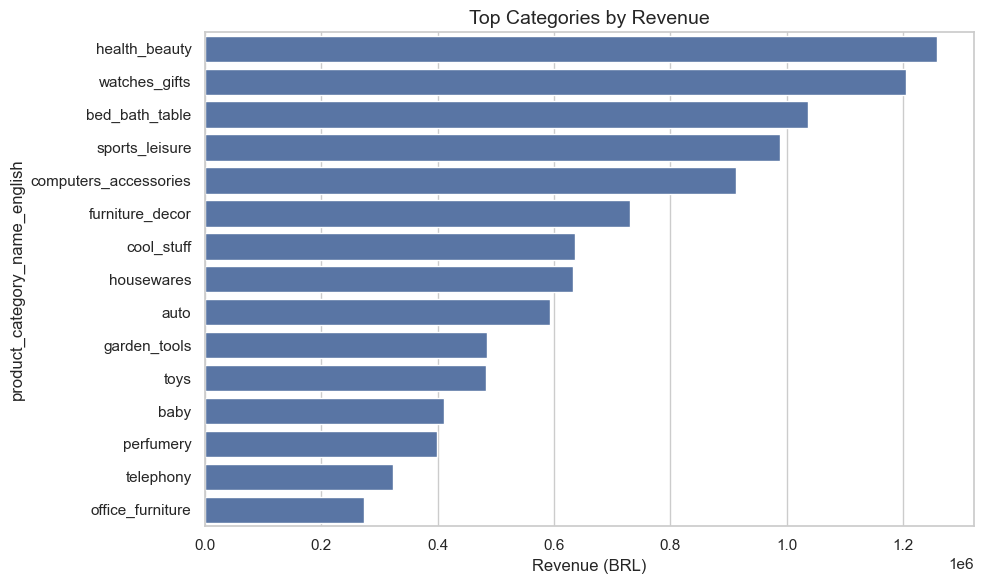

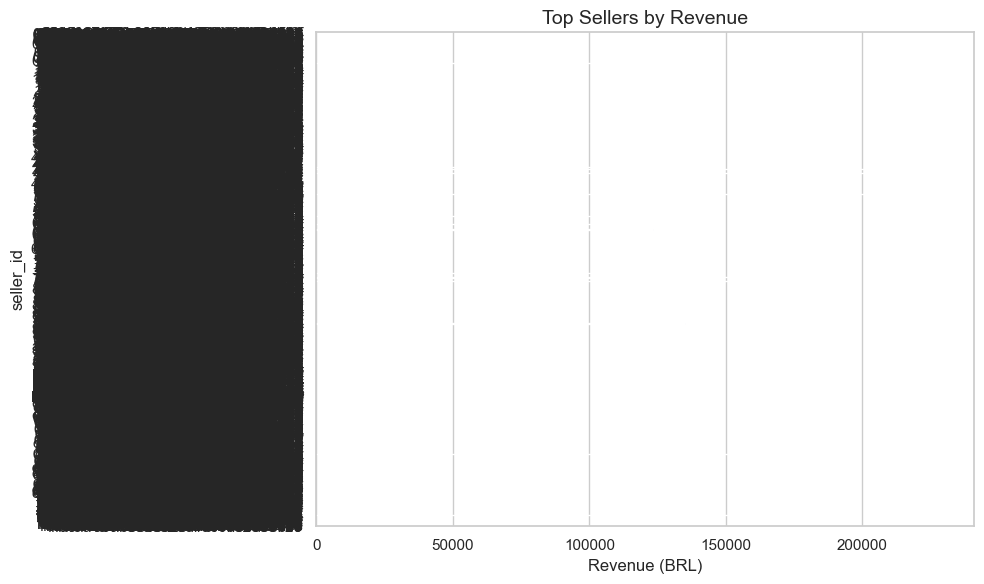

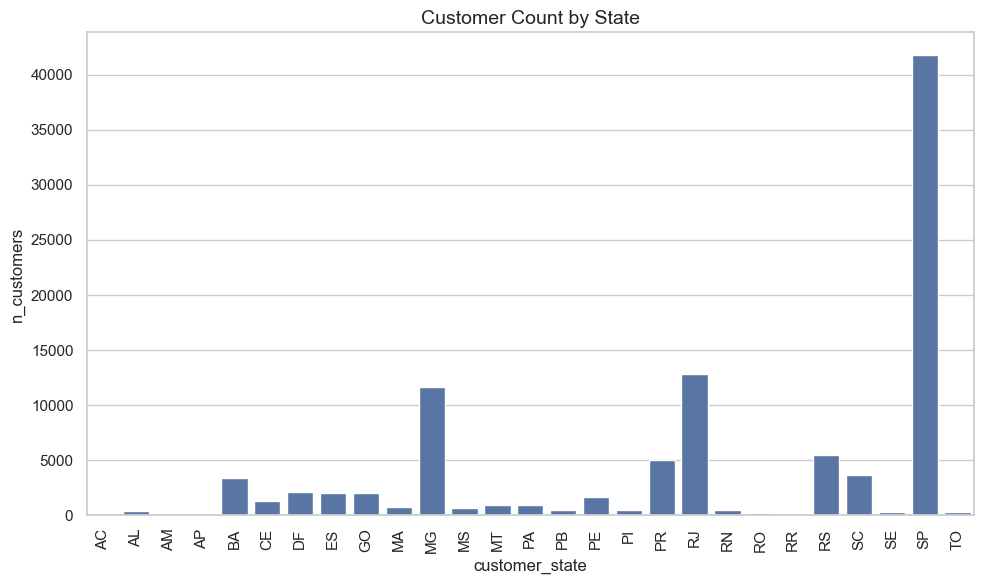

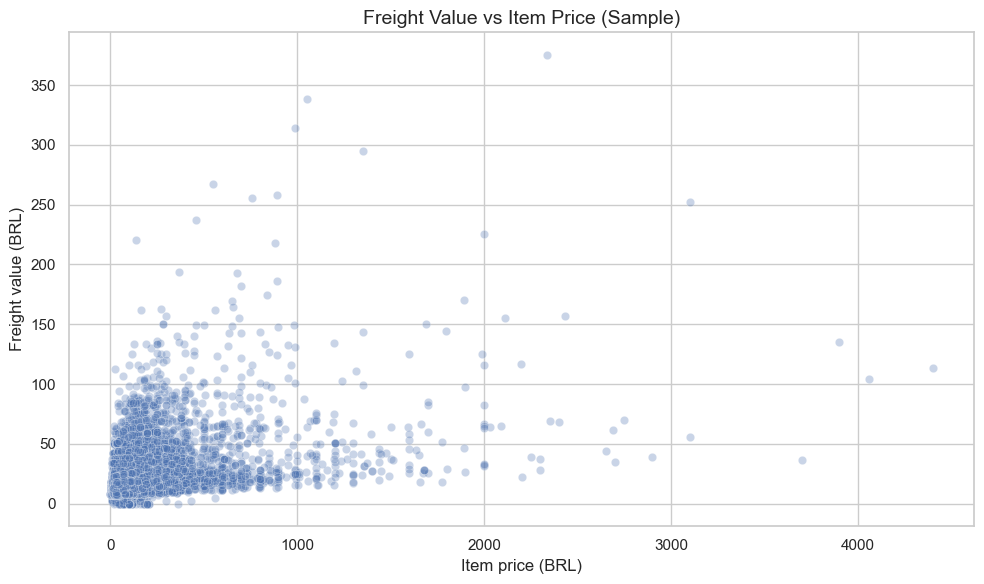

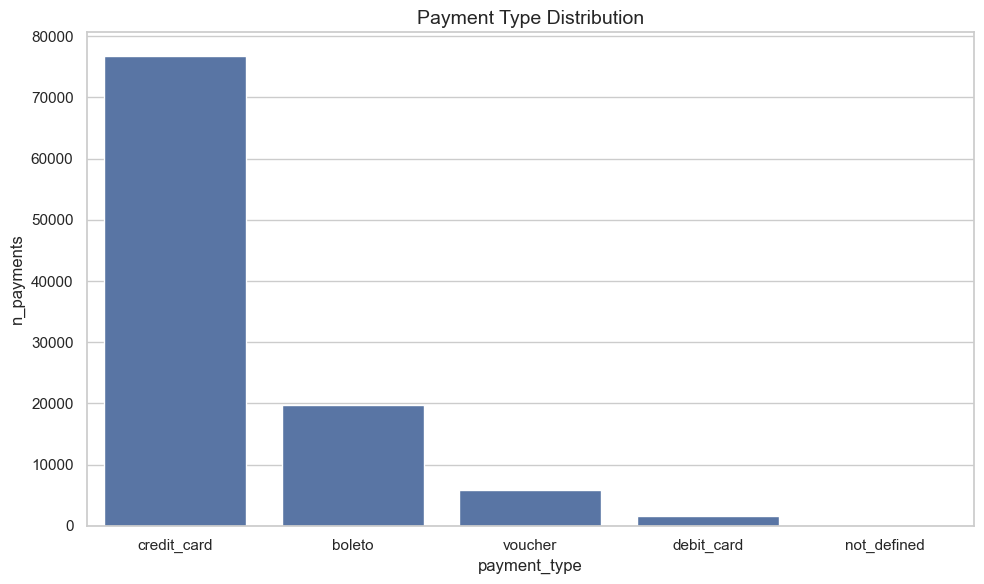

In [7]:
# 3.3 Category, Seller, Geography, and Payment Behavior



customers = clean_tables['customers']

order_items = clean_tables['order_items']

products = clean_tables['products']

sellers = clean_tables['sellers']

payments = clean_tables['payments']



# Category performance

items_with_cat = order_items.merge(

    products[['product_id', 'product_category_name_english']],

    on='product_id',

    how='left',

)

cat_perf = (

    items_with_cat.groupby('product_category_name_english')

    .agg(revenue=('price', 'sum'), n_items=('order_item_id', 'count'))

    .sort_values('revenue', ascending=False)

    .head(15)

    .reset_index()

)



# Seller performance

items_with_seller = order_items.merge(

    sellers[['seller_id', 'seller_city', 'seller_state']], on='seller_id', how='left'

)

seller_perf = (

    items_with_seller.groupby('seller_id')

    .agg(revenue=('price', 'sum'), n_items=('order_item_id', 'count'))

    .sort_values('revenue', ascending=False)

    .head(15)

    .reset_index()

)



plot_category_and_seller_performance(cat_perf, seller_perf)

plot_geography_and_payments(customers, payments, order_items)

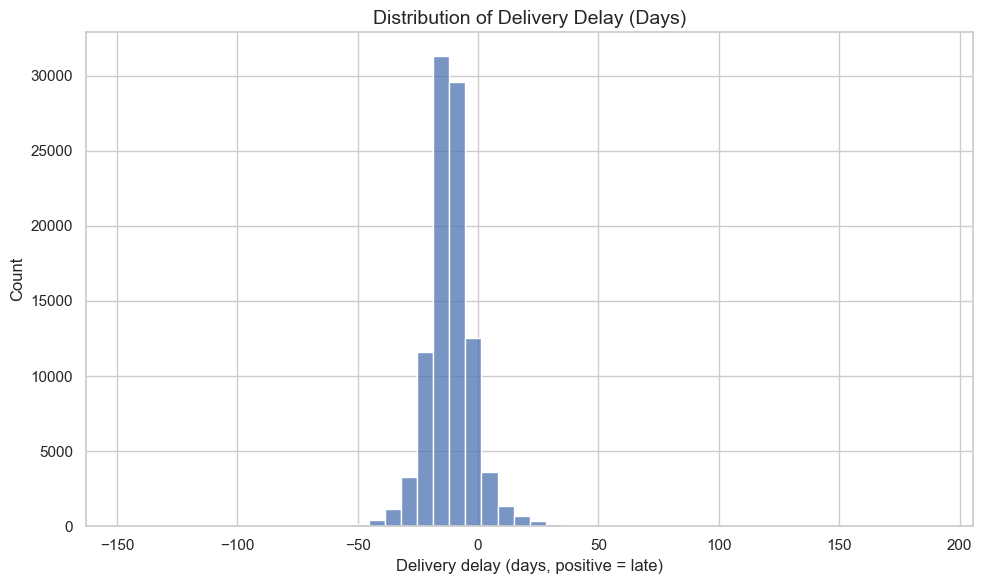

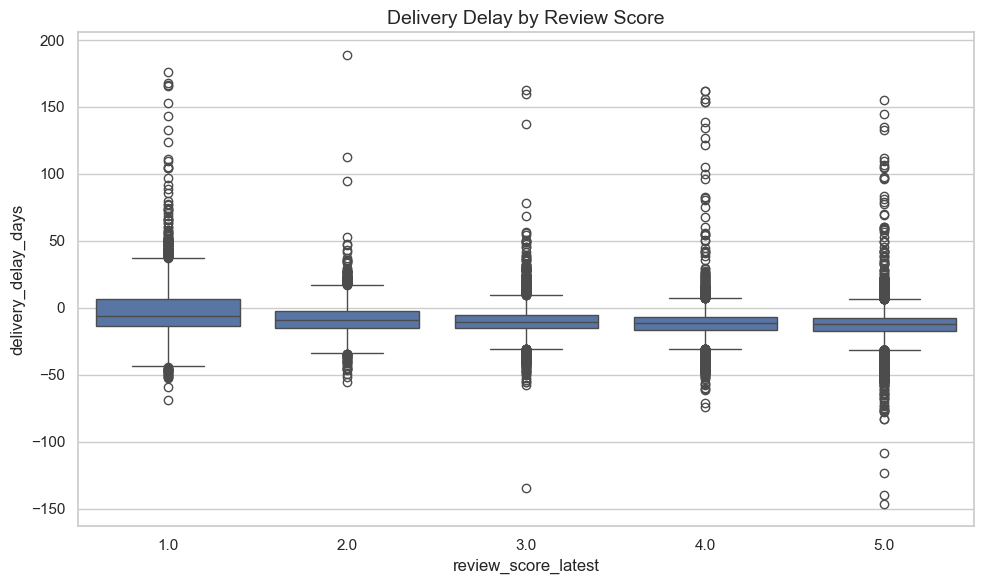

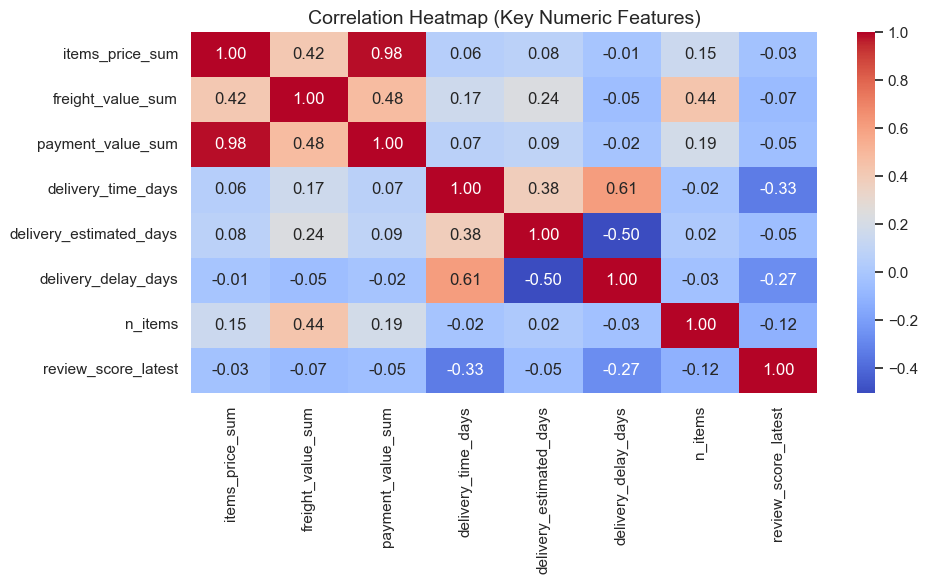

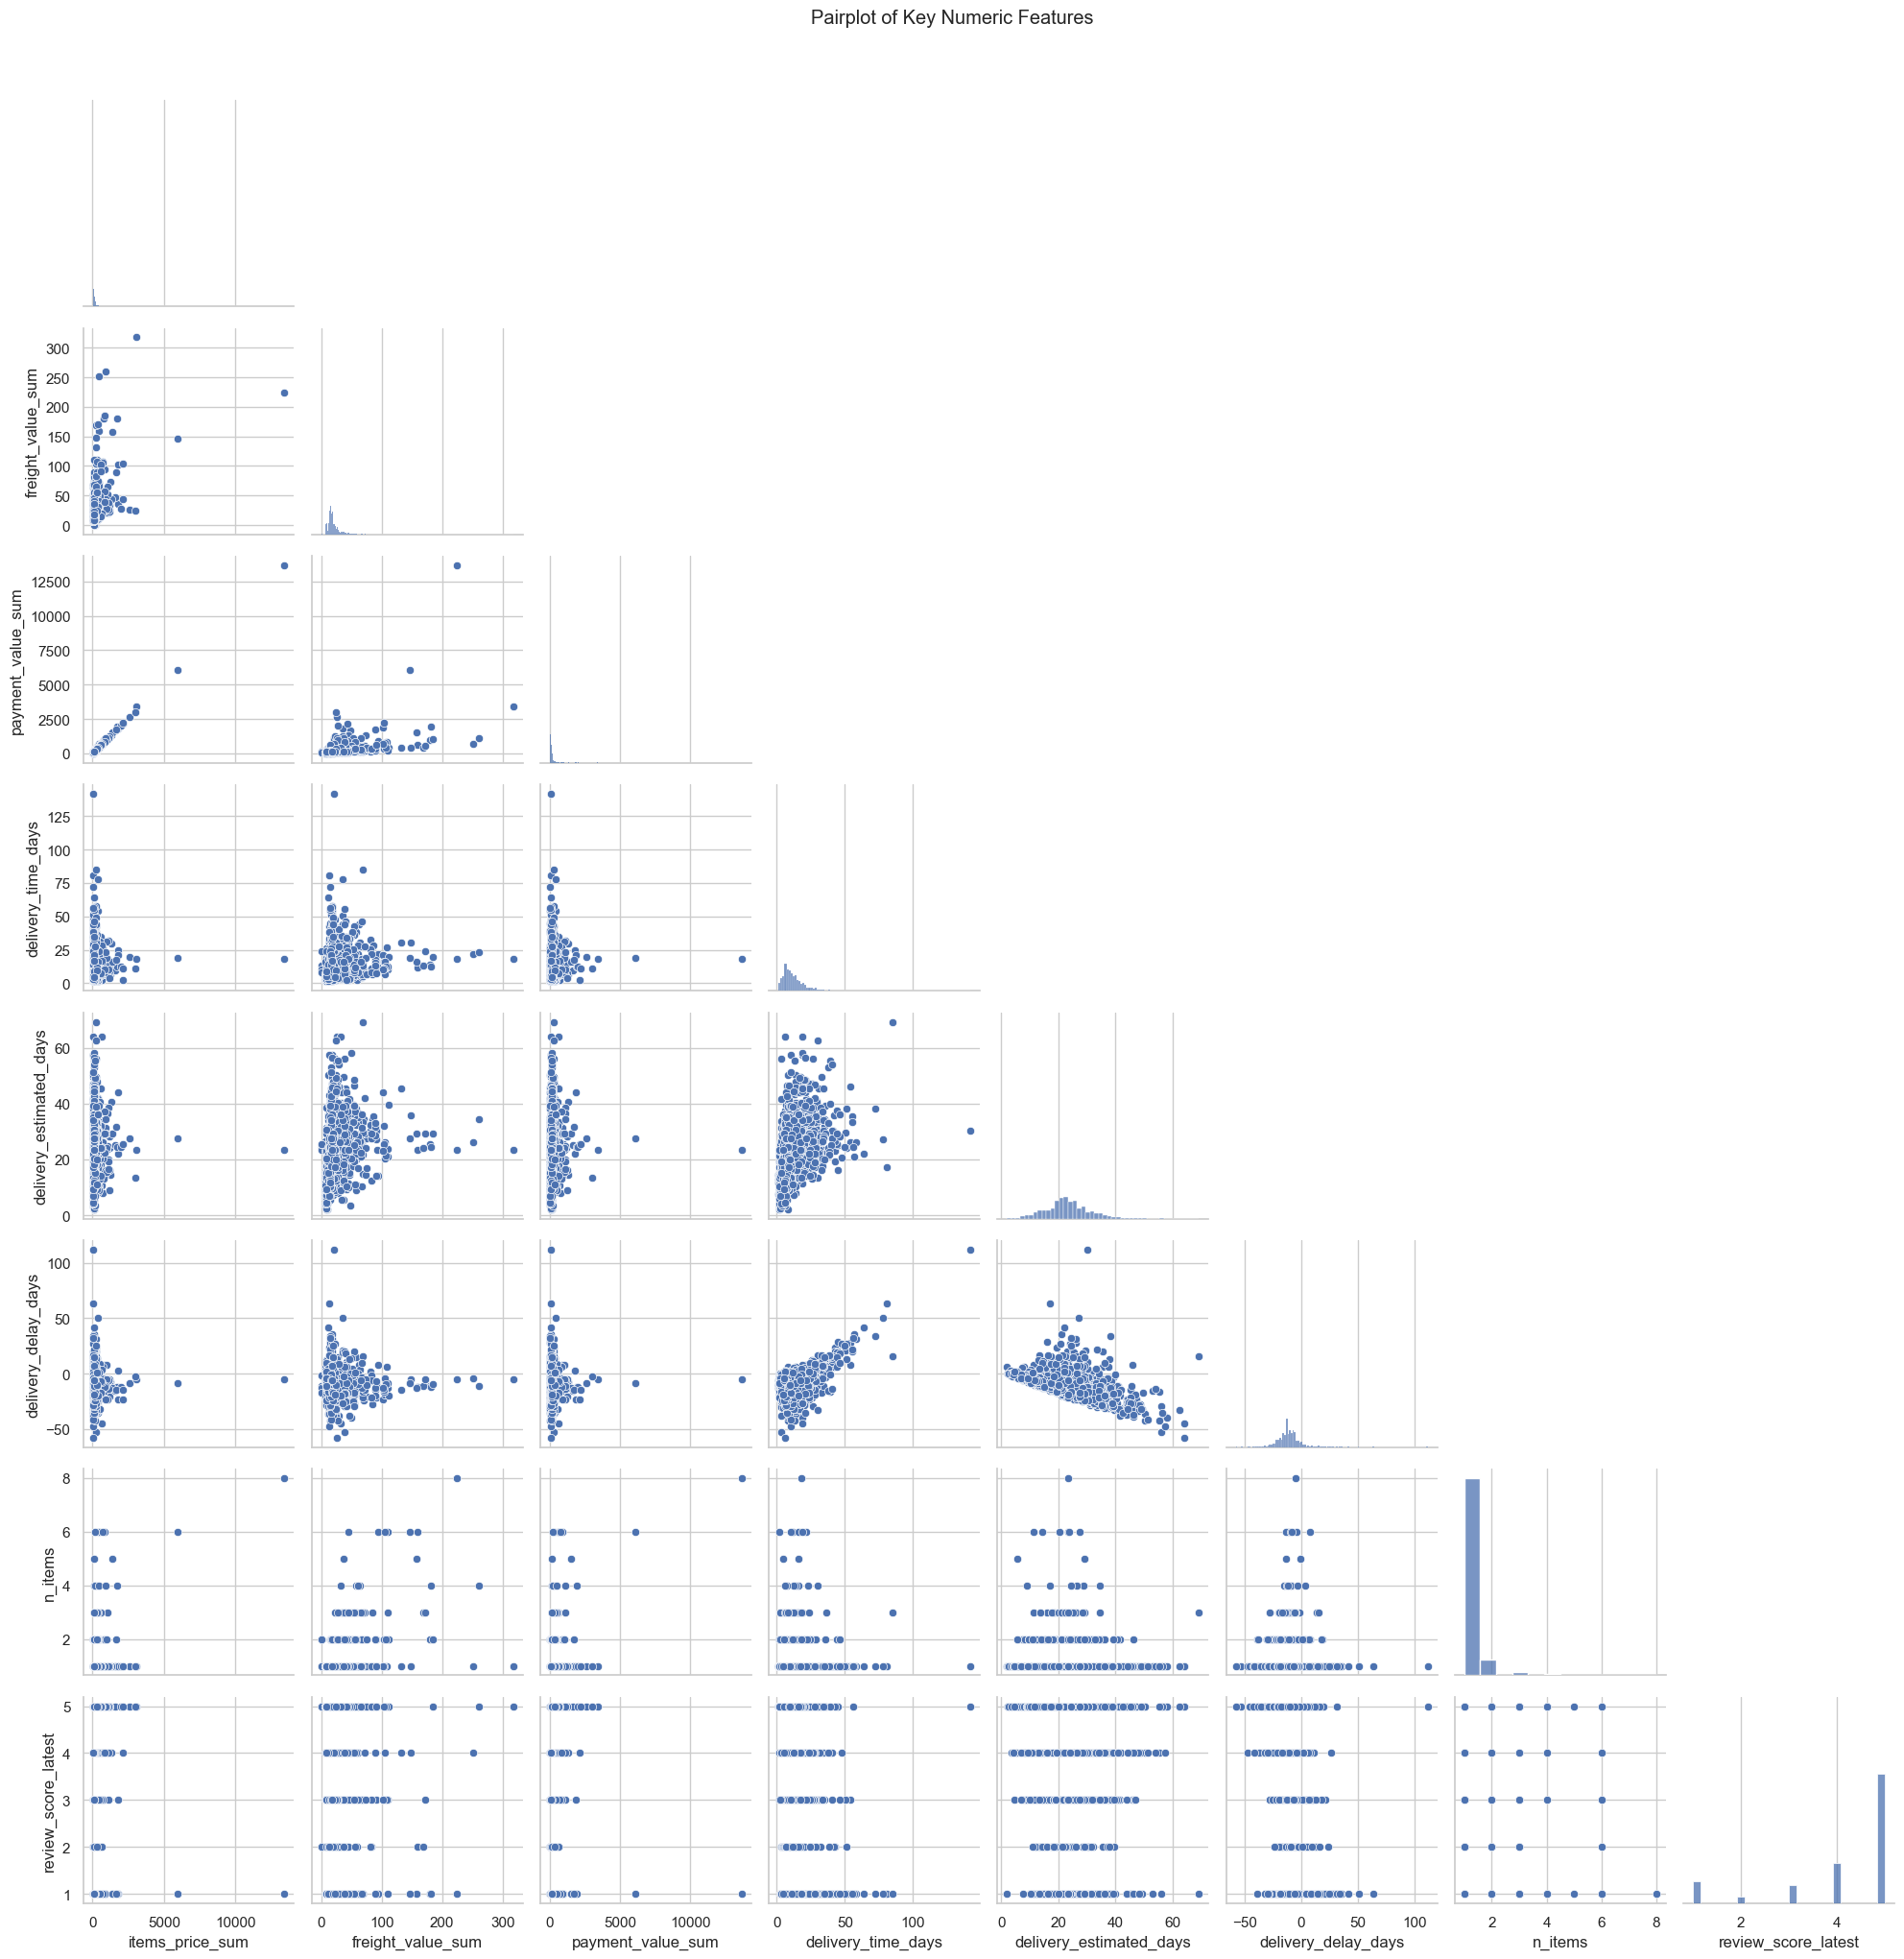

In [8]:
# 3.4 Delivery Delay and Correlations



orders_eda = add_delivery_features(orders_eda)

plot_delivery_and_correlations(orders_eda)

## 4. Feature Engineering



We now construct reusable, modeling-ready features:

- Time features: year, month, weekday, hour, weekend flag

- Delivery features: total lead time, estimated time, and delay vs estimate

- Monetary features: total order value, average item price

- Customer CLV and repeat behavior

- Review-based aggregates for customers, products, and sellers

- Geographic distance between customer and seller (haversine)



In [9]:
# Local interaction feature engineering utilities

import numpy as np

def add_interaction_features(df):
    """Add interaction features that capture freight economics and delay impact.

    Parameters
    ----------
    df : pandas.DataFrame
        Order-level feature table.

    Returns
    -------
    pandas.DataFrame
        Copy of df with additional interaction features.
    """

    # Work on a copy to avoid mutating the original input
    df = df.copy()

    # 1) Freight-to-price ratio: how expensive shipping is relative to items
    #    freight_to_price_ratio = freight_value_sum / items_price_sum
    #    - If items_price_sum is 0 or missing, we define the ratio as 0
    if "freight_value_sum" in df.columns and "items_price_sum" in df.columns:
        denom = df["items_price_sum"].replace(0, np.nan)
        ratio = df["freight_value_sum"] / denom
        # Replace inf and NaN (from division by zero or missing values) with 0
        ratio = ratio.replace([np.inf, -np.inf], np.nan).fillna(0)
        df["freight_to_price_ratio"] = ratio
    else:
        # If required columns are missing, still create the feature as 0
        df["freight_to_price_ratio"] = 0.0

    # 2) Monetary impact of delay: how much value is affected by late delivery
    #    delay_x_total_value = delivery_delay_days * total_order_value
    #    - Missing delay or value is treated as 0
    if "delivery_delay_days" in df.columns:
        delay = df["delivery_delay_days"].fillna(0)
    else:
        delay = 0

    if "total_order_value" in df.columns:
        total_val = df["total_order_value"].fillna(0)
    else:
        total_val = 0

    df["delay_x_total_value"] = delay * total_val

    # Defined locally to avoid notebook/module reload issues.
    return df

In [10]:
# 4.1 Build Enriched Order-Level Feature Table


geolocation = clean_tables['geolocation']


# Start from base orders and iteratively add features
orders_fe = orders_base.copy()
orders_fe = add_time_features(orders_fe)
orders_fe = add_delivery_features(orders_fe)
orders_fe = add_monetary_features(orders_fe)
orders_fe, clv_df = add_customer_clv_features(orders_fe)
orders_fe, prod_rev_agg, seller_rev_agg = add_review_aggregates(
    orders_fe, order_items_ext, clean_tables['reviews']
)
orders_fe = add_geolocation_distance(
    orders_fe,
    customers=clean_tables['customers'],
    sellers=clean_tables['sellers'],
    geolocation=geolocation,
    order_items_ext=order_items_ext,
)
orders_fe = add_interaction_features(orders_fe)


# Define model feature configurations
model_cfg = build_model_feature_sets(orders_fe)


orders_fe.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,avg_item_price,customer_n_orders,customer_total_revenue,customer_avg_order_value,customer_last_purchase,customer_review_score_mean,customer_review_count,distance_km_mean,freight_to_price_ratio,delay_x_total_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,29.99,1,38.71,38.71,2017-10-02 10:56:33,4.0,1,18.576110,0.290764,-275.130877
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,118.70,1,141.46,141.46,2018-07-24 20:41:37,4.0,1,851.495069,0.191744,-757.621448
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,159.90,1,179.12,179.12,2018-08-08 08:38:49,5.0,1,514.410666,0.120200,-3089.013545


## 5. Predictive Modeling



We now build two main predictive tasks plus an optional CLV model:



1. **Delivery Delay Regression** – Predict days late given order, product, customer, payment, and distance features.

2. **Review Score Classification** – Predict review_score using order value, delay, CLV, and payment behavior.

3. **CLV Regression** – Predict CLV for the top 5% of customers.





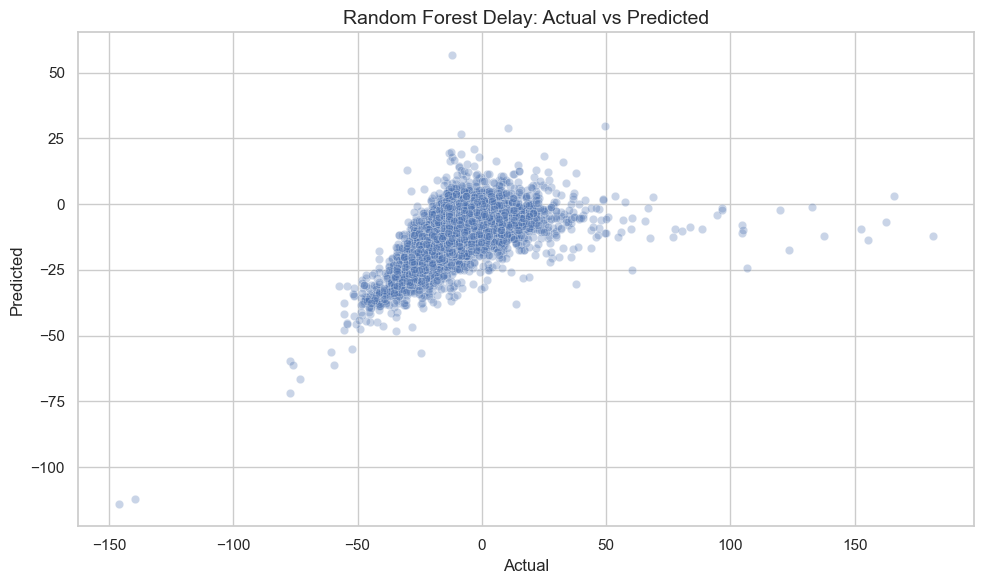

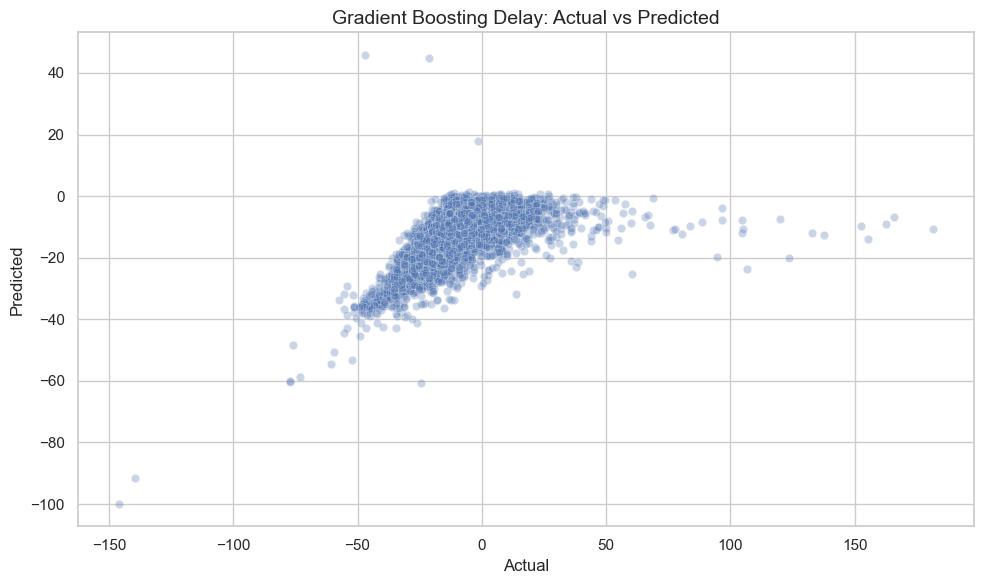

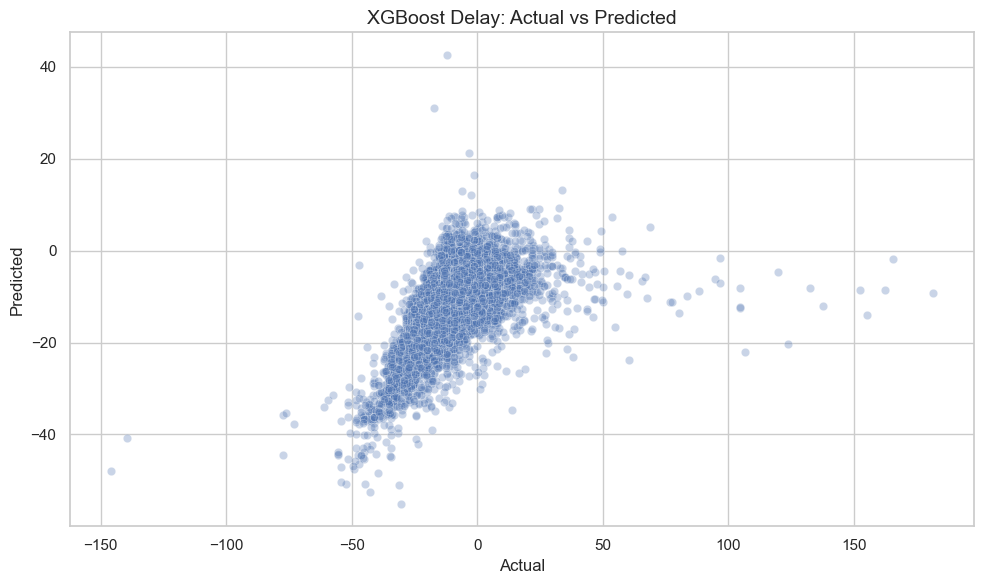

,rmse,mae,r2
RandomForest,8.564794,5.054587,0.355594
GradientBoosting,8.544074,4.966455,0.358708
XGBoost,8.454831,4.861425,0.372034


In [11]:
# 5.1 Delivery Delay Regression



delay_cfg = model_cfg['delay']

X_train_delay, X_test_delay, y_train_delay, y_test_delay, preproc_delay = build_delay_dataset(

    orders_fe,

    numeric_features=delay_cfg['numeric'],

    categorical_features=delay_cfg['categorical'],

)



delay_metrics, delay_models = train_delay_models(

    X_train_delay, X_test_delay, y_train_delay, y_test_delay, preproc_delay

)



pd.DataFrame(delay_metrics).T

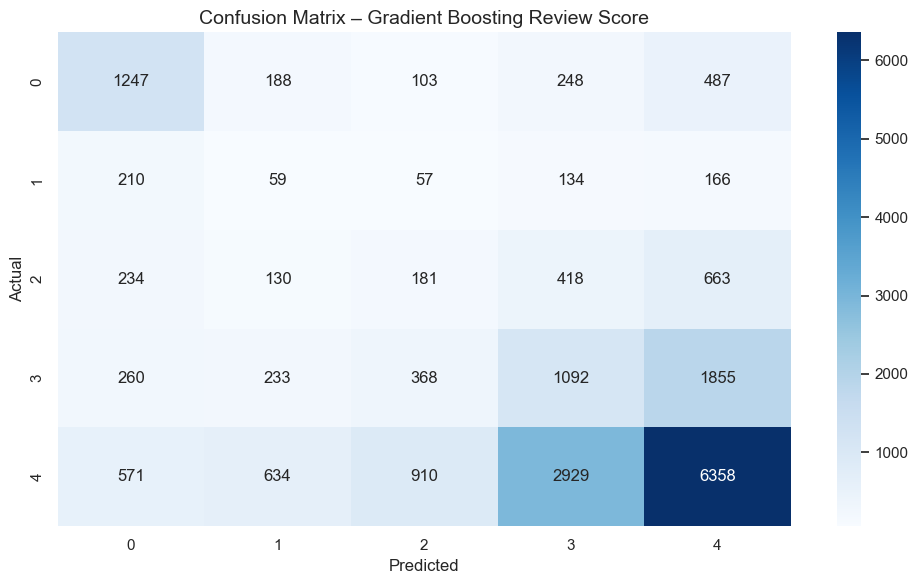

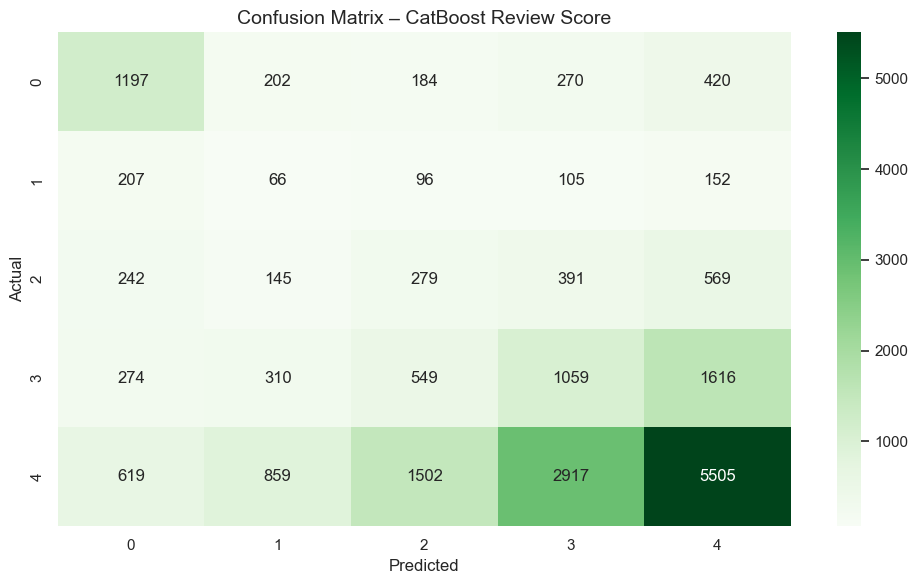

,model,accuracy,f1_macro,f1_weighted
0,GradientBoostingClassifier,0.452850,0.311081,0.470934
1,CatBoostClassifier,0.410742,0.299329,0.441338


In [12]:
# 5.2 Review Score Classification


review_cfg = model_cfg['review']
X_train_rev, X_test_rev, y_train_rev, y_test_rev, preproc_rev, X_review_all, y_review_all = build_review_dataset(
    orders_fe,
    numeric_features=review_cfg['numeric'],
    categorical_features=review_cfg['categorical'],
)


review_metrics = train_review_models(
    X_train_rev,
    X_test_rev,
    y_train_rev,
    y_test_rev,
    preproc_rev,
    X_review_all,
    y_review_all,
)


# Summarize main accuracy and F1 metrics
pd.DataFrame(
    [
        {
            "model": name,
            "accuracy": m.get("accuracy"),
            "f1_macro": m.get("f1_macro"),
            "f1_weighted": m.get("f1_weighted"),
        }
        for name, m in review_metrics.items()
    ],
)

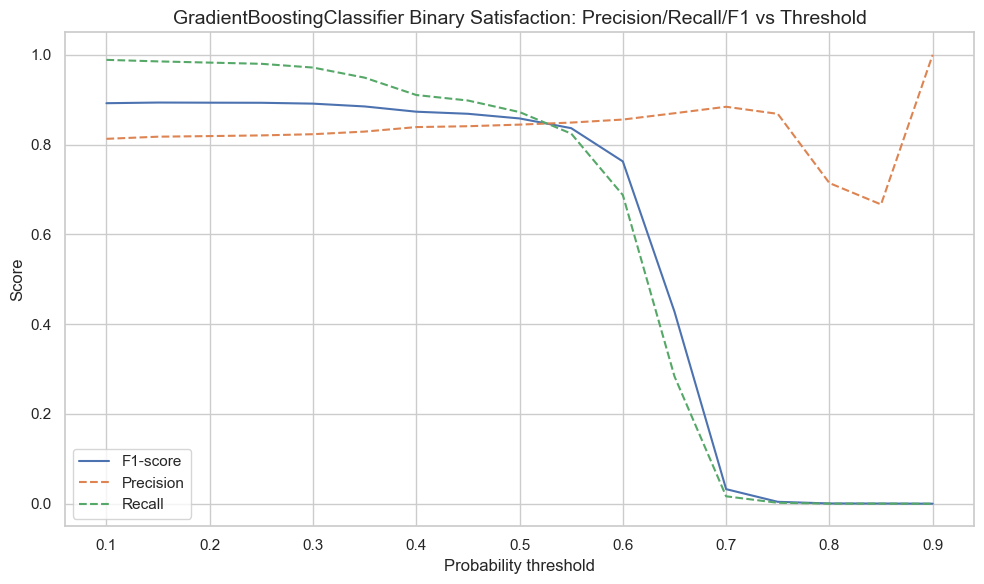

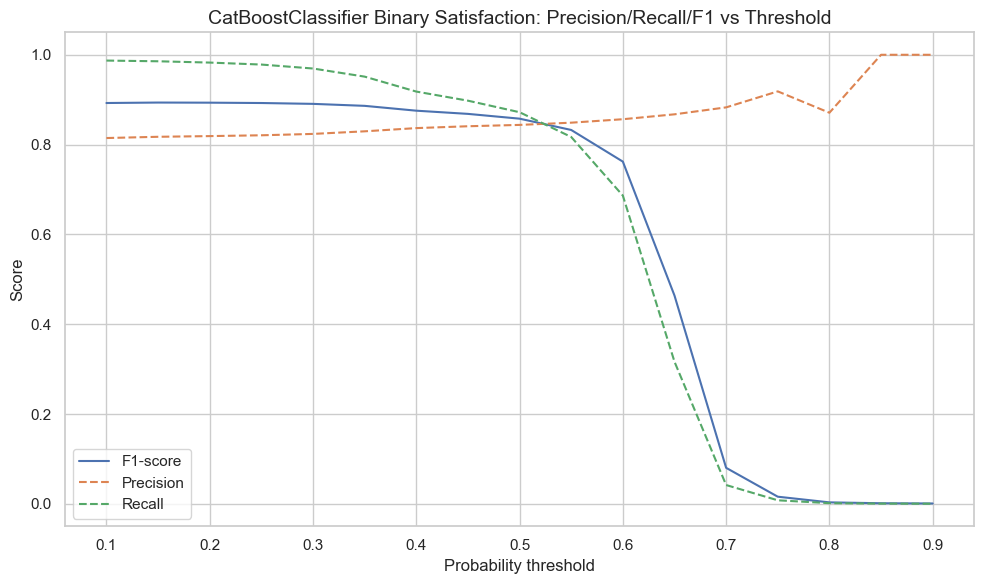

,model,accuracy,roc_auc,f1_macro,f1_weighted,f1_positive,best_threshold,f1_at_best_threshold,precision_at_best_threshold,recall_at_best_threshold
0,GradientBoostingClassifier,0.779526,0.715477,0.681498,0.775058,0.858196,0.15,0.893620,0.817567,0.985273
1,CatBoostClassifier,0.778822,0.715617,0.680326,0.774281,0.857771,0.15,0.893645,0.817428,0.985536


In [13]:
# 5.2b Customer Satisfaction (Binary)


# Create binary target: 1 if review >= 4, else 0
orders_fe = add_binary_review_target(orders_fe)


# Use the same feature set as the multiclass review model
review_cfg = model_cfg['review']
binary_features = review_cfg['numeric'] + review_cfg['categorical']


# Train binary models (GradientBoosting + CatBoost ) with
# class balancing and threshold tuning enabled by default for better
# handling of the minority (dissatisfied) class.
binary_results = train_binary_review_models(
    orders_fe,
    binary_features,
    use_class_weight=True,
    tune_threshold=True,
)


binary_results

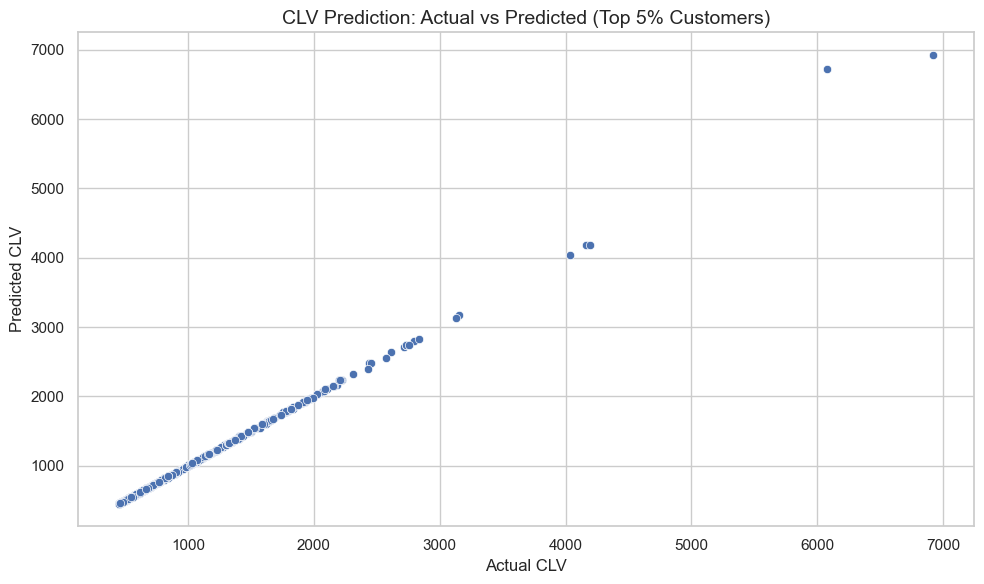

{'rmse': 21.04041255393054, 'mae': 3.8034953702611176}

In [14]:
# 5.3 CLV Regression for Top 5% Customers



clv_metrics = build_and_train_clv_model(clv_df)

clv_metrics

## 6. Business Insights & KPI Summary



In this section we translate the analysis and models into business language:



- Top-performing products, categories, and sellers

- High-CLV customers and repeat purchase behavior

- Regions with most delivery delays and prediction errors

- Impact of payment methods and distance on delays

- Relationship between delivery performance and review scores



These insights drive recommendations for logistics optimization and customer retention.

In [15]:
# 6.1 Core KPIs and Top Entities



total_revenue = orders_fe['total_order_value'].sum()

n_orders_total = orders_fe['order_id'].nunique()

avg_order_value = orders_fe['total_order_value'].mean()

avg_review_score = orders_fe['review_score_latest'].mean()

late_delivery_rate = orders_fe['is_late'].mean()



top_categories_kpi = cat_perf.head(5)[['product_category_name_english', 'revenue']]

top_sellers_kpi = seller_perf.head(5)[['seller_id', 'revenue']]

top_customers_clv = clv_df.sort_values('customer_total_revenue', ascending=False).head(5)[

    ['customer_id', 'customer_total_revenue', 'customer_n_orders']

]



kpi_table = pd.DataFrame({

    'KPI': [

        'Total revenue (BRL)',

        'Number of orders',

        'Average order value (BRL)',

        'Average review score (1–5)',

        'Late delivery rate',

    ],

    'Value': [

        f"{total_revenue:,.0f}",

        f"{n_orders_total:,}",

        f"{avg_order_value:,.2f}",

        f"{avg_review_score:.2f}",

        f"{late_delivery_rate*100:.1f}%",

    ],

})



kpi_table

,KPI,Value
0,Total revenue (BRL),"15,843,553"
1,Number of orders,"99,441"
2,Average order value (BRL),159.33
3,Average review score (1–5),4.09
4,Late delivery rate,7.9%


In [16]:
display(top_categories_kpi)

display(top_sellers_kpi)

display(top_customers_clv)



# Example: where delay predictions struggle the most by state (Random Forest)

delay_df = orders_fe.dropna(subset=['delivery_delay_days']).copy()

rf_model = delay_models['RandomForest']

rf_preds = rf_model.predict(X_test_delay)



delay_pred_df = pd.DataFrame({

    'order_id': delay_df.loc[X_test_delay.index, 'order_id'],

    'customer_state': delay_df.loc[X_test_delay.index, 'customer_state'],

    'actual_delay': y_test_delay,

    'pred_delay_rf': rf_preds,

})

delay_pred_df['abs_error'] = (delay_pred_df['actual_delay'] - delay_pred_df['pred_delay_rf']).abs()



state_error = delay_pred_df.groupby('customer_state')['abs_error'].mean().sort_values(ascending=False)

state_error.head(10)

,product_category_name_english,revenue
0,health_beauty,1258681.34
1,watches_gifts,1205005.68
2,bed_bath_table,1036988.68
3,sports_leisure,988048.97
4,computers_accessories,911954.32


,seller_id,revenue
0,4869f7a5dfa277a7dca6462dcf3b52b2,229472.63
1,53243585a1d6dc2643021fd1853d8905,222776.05
2,4a3ca9315b744ce9f8e9374361493884,200472.92
3,fa1c13f2614d7b5c4749cbc52fecda94,194042.03
4,7c67e1448b00f6e969d365cea6b010ab,187923.89


,customer_id,customer_total_revenue,customer_n_orders
8546,1617b1357756262bfa56ab541c47bc16,13664.08,1
91985,ec5b2ba62e574342386871631fafd3fc,7274.88,1
77522,c6e2731c5b391845f6800c97401a43a9,6929.31,1
95124,f48d464a0baaea338cb25f816991ab1f,6922.21,1
24771,3fd6777bbce08a352fddd04e4a7cc8f6,6726.66,1


/var/folders/kj/l_jbtj9n7678blgcl5zmd3xm0000gn/T/ipykernel_7842/3100901381.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  state_error = delay_pred_df.groupby('customer_state')['abs_error'].mean().sort_values(ascending=False)


customer_state
RR    14.511055
AP    13.482031
RN     9.701280
AM     9.385690
AL     9.360391
PA     9.277189
CE     8.354048
PI     8.316797
SE     7.887879
MA     7.866281
Name: abs_error, dtype: float64

In [17]:
# 7. Outputs & Exports

# Purpose: Persist enriched data and rely on src/utils paths so others can rerun easily.


enriched_path = OUTPUTS_DIR / 'enriched_orders.csv'
orders_fe.to_csv(enriched_path, index=False)

# small pre-aggregated tables for dashboards (top 10 categories/sellers)
# These make dashboard loading faster and keep business logic consistent across apps.
top10_categories = cat_perf.head(10).copy()
top10_sellers = seller_perf.head(10).copy()

top10_categories_path = OUTPUTS_DIR / 'top10_categories_revenue.csv'
top10_sellers_path = OUTPUTS_DIR / 'top10_sellers_revenue.csv'

top10_categories.to_csv(top10_categories_path, index=False)
top10_sellers.to_csv(top10_sellers_path, index=False)

enriched_path, orders_fe.shape, top10_categories_path, top10_sellers_path

(PosixPath('/Users/mac/Desktop/business-data-science/Olist-DS-Project/outputs/enriched_orders.csv'),
 (99441, 44),
 PosixPath('/Users/mac/Desktop/business-data-science/Olist-DS-Project/outputs/top10_categories_revenue.csv'),
 PosixPath('/Users/mac/Desktop/business-data-science/Olist-DS-Project/outputs/top10_sellers_revenue.csv'))

## 8. Executive Summary 



This final section summarizes the main findings .

### Top 10 Figures

Below are ten key figures saved to the `figures/` folder that best
summarize the analysis and modeling story. Filenames are suitable for
direct inclusion in slides or a portfolio:

1. `eda_missingness_top.png` – Missingness heatmap highlighting which tables/columns are most complete.
2. `dist_items_price_sum.png` – Distribution of total item prices per order (revenue per order).
3. `orders_per_month.png` – Monthly orders time series showing demand seasonality and growth.
4. `top_categories_revenue.png` – Top 10 product categories by revenue.
5. `top_sellers_revenue.png` – Top 10 sellers by revenue.
6. `customers_by_state.png` – Customer concentration and demand by Brazilian state.
7. `delivery_delay_distribution.png` – Distribution of delivery delays in days, highlighting long tails.
8. `delay_by_review_score.png` – Average delivery delay by review score (service quality vs. satisfaction).
9. `random_forest_delay_actual_vs_pred.png` – Random Forest delay regression: actual vs predicted scatter.
10. `clv_actual_vs_predicted.png` – CLV regression: actual vs predicted for top 5% customers.

Additional figures (e.g., correlation heatmaps, payment distributions, and
multiclass review confusion matrices) are also saved in `figures/` and can
be used as needed.

### Executive Summary – Business Interpretation



- **Revenue & Demand:** Revenue is concentrated in a subset of categories and sellers, with clear seasonality and growth over time. A small fraction of customers contributes disproportionately to GMV.

- **Delivery Performance:** Late deliveries materially increase as distance and estimated delivery times grow. States that are farther from key hubs exhibit higher delays and prediction errors.

- **Customer Satisfaction:** Review scores drop noticeably when deliveries are late; payment type and order value also show secondary relationships with satisfaction.

- **High-Value Customers:** CLV analysis shows that focusing on the top 5% of customers for retention (e.g., perks, faster shipping) can generate significant incremental revenue.



**Recommendations**

1. **Logistics Optimization:** Prioritize investments (new hubs, carrier SLAs) in states with the highest delay rates and largest absolute delay prediction errors.

2. **Freight Strategy:** Revisit freight pricing rules for extreme freight-to-price ratios to avoid unprofitable or abandoned orders.

3. **Retention Programs:** Create targeted campaigns for high-CLV customers, especially those with recent low review scores, to prevent churn.

4. **Seller & Product Quality:** Monitor low-scoring sellers/products with long delays; enforce SLAs or provide operational support.
